In [35]:
from oauth2client.service_account import ServiceAccountCredentials
import gspread, pprint
import pandas as pd
import numpy as np
from datetime import datetime

In [36]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('bplinebot-3ccea59ad6d6.json', scope)
client = gspread.authorize(creds)
pp = pprint.PrettyPrinter()
def get_client():
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('bplinebot-3ccea59ad6d6.json', scope)
    client = gspread.authorize(creds)
    return client

In [37]:
#sheet = client.open('AbbokIncomeAssesmentV03').get_worksheet(2)
spread = client.open('userCheckin')

In [38]:
spread.worksheets()

[<Worksheet 'sum' id:576946557>,
 <Worksheet 'log' id:0>,
 <Worksheet 'type' id:252782580>,
 <Worksheet 'userStatus' id:1060831238>,
 <Worksheet 'key' id:1108603979>]

In [39]:
sheet = spread.worksheet('log')

In [40]:
list_of_lists = sheet.get_all_values()

In [41]:
df = pd.DataFrame(list_of_lists[1:], columns = list_of_lists[0])
df = df[pd.to_datetime(df['DATE']).dt.month == datetime.today().month]#datetime.today().month
df.head(10)

,ID,DATE,TIME,USER_ID,TYPE
438,439,2019/09/02,09:29 AM,2,1
439,440,2019/09/02,09:41 AM,3,1
440,441,2019/09/02,09:42 AM,7,1
441,442,2019/09/02,10:24 AM,8,1
442,443,2019/09/02,12:20 PM,1,1
443,444,2019/09/02,12:22 PM,4,1
444,445,2019/09/02,07:18 PM,2,0
445,446,2019/09/02,07:30 PM,8,0
446,447,2019/09/02,07:45 PM,1,0
447,448,2019/09/02,07:45 PM,4,0


In [34]:
df['TIME'] = pd.to_datetime(df['TIME']).values.astype(np.int64)
df['DATE'] = pd.to_datetime(df['DATE']).dt.date
df['USER_ID'] = df['USER_ID'].astype(int)
df['TYPE'] = df['TYPE'].astype(int)
df = df.set_index('ID')
df.shape

(88, 4)

In [24]:
df2 = pd.DataFrame(df.groupby(['USER_ID', 'TYPE'])['TIME'].mean())

In [12]:
df2['INOUT'] = pd.to_datetime(df2['TIME']).dt.time
df2

TIME            INOUT
USER_ID TYPE                                      
1       0     1568060584615384576  20:23:04.615384
        1     1568037600000000000         14:00:00
2       0     1568044226249999616  15:50:26.249999
        1     1568026402499999744  10:53:22.499999
3       0     1568051747142857216  17:55:47.142857
        1     1568028012857142784  11:20:12.857142
4       0     1568059029230769152  19:57:09.230769
        1     1568034327692307456  13:05:27.692307
7       0     1568056332631578624  19:12:12.631578
        1     1568022221052631808  09:43:41.052631
8       0     1568055160000000000         18:52:40
        1     1568022765000000256         09:52:45

In [13]:
df2 = df2.reset_index()

In [14]:
w_out = df2[df2['TYPE'] == 0].reset_index().drop(["index","TYPE"], axis=1)
w_in = df2[df2['TYPE'] == 1].reset_index().drop(["index","TYPE"], axis=1)

In [15]:
w_total = w_out.copy()
w_total['TIME'] = w_out['TIME'] - w_in['TIME']
w_total

,USER_ID,TIME,INOUT
0,1,22984615384576,20:23:04.615384
1,2,17823749999872,15:50:26.249999
2,3,23734285714432,17:55:47.142857
3,4,24701538461696,19:57:09.230769
4,7,34111578946816,19:12:12.631578
5,8,32394999999744,18:52:40


In [57]:
w_total['TIME'] = pd.to_datetime(w_total['TIME']).dt.time

In [58]:
w_total

,USER_ID,TIME,INOUT
0,1,06:36:58,19:58:48
1,2,06:49:54,17:46:48
2,3,09:35:37.500000,20:14:00
3,4,06:11:22.500000,19:10:00
4,7,09:21:03.818181,19:07:42
5,8,08:54:45,18:36:00


In [59]:
w_total[w_total['USER_ID'] == 1]['TIME'].values[0].strftime("%H:%M:%S")

'06:36:58'

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

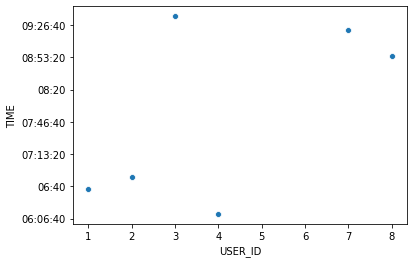

In [61]:
base_color = sb.color_palette()[0]
sb.scatterplot(data = w_total, y = 'TIME', x='USER_ID', color = base_color);

In [17]:
def get_user_key(approve=True, check_is_in=False, isw='out'):
    client = get_client()
    sheet = client.open('userCheckin').worksheet('userStatus')
    user_id = sheet.col_values(2)[1:]
    is_approve = sheet.col_values(6)[1:]
    is_in = sheet.col_values(4)[1:]
    is_in = [int(i) for i in is_in]
    is_approve = [1 if i == 'APPROVE' else 0 for i in is_approve]
    approve_mem = [id for id, i in zip(user_id, is_approve) if i == 1]

    if approve is False:
        print('1')
        return user_id
    else:
        if check_is_in:
            if isw == 'out':
                out_mem = [id for id, i in zip(user_id, is_in) if i == 0]
                print('2')
                return out_mem
            if isw == 'in':
                in_mem = [id for id, i in zip(user_id, is_in) if i == 1]
                print('3')
                return in_mem
            print('4')
        return approve_mem

In [21]:
get_user_key(check_is_in=True, isw='in')

3


['U7612d77bbca83f04d6acf5e27333edeb',
 'U262184d96cc22dfb837493e3ff6ca85a',
 'Ub4cd6bb2dc9548dd416a35e5b7488c09',
 'Ube7c6d3358f6994218ffb623d4d8a06e',
 'U5ac4ec185e02185b6eae0d54d56f7d10']

In [19]:
for i in get_user_key():
    print(i)

U7612d77bbca83f04d6acf5e27333edeb
U262184d96cc22dfb837493e3ff6ca85a
U03fe1d43c072db5c3dde2f2a20fddcb9
Ub4cd6bb2dc9548dd416a35e5b7488c09
Ube7c6d3358f6994218ffb623d4d8a06e
U5ac4ec185e02185b6eae0d54d56f7d10


In [17]:
'!ct sfasfasfad'.startswith('!ct ')

True

In [19]:
client = get_client()
sheet = client.open('userCheckin').worksheet('userStatus')
user_id = sheet.col_values(2)[1:]
user_name = sheet.col_values(3)[1:]
is_in = sheet.col_values(4)[1:]
is_inR = [u for i, u in zip(is_in, user_id) if i == '1']
user_in = [y for i, y in zip(is_in, user_name) if i == '1']


In [21]:
user_in

['TAAN', 'SNOOK', 'TOEY', 'NUT', 'JOEY']

In [18]:
for i, v in zip(is_in, user_name):
    print(i, v)

U262184d96cc22dfb837493e3ff6ca85a BEST
U03fe1d43c072db5c3dde2f2a20fddcb9 TAAN
Ube7c6d3358f6994218ffb623d4d8a06e SNOOK
U5ac4ec185e02185b6eae0d54d56f7d10 TEAM
U99cc103c604322964f2d16dd8cb52d8c BAM


In [ ]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/dialogflow']
creds = ServiceAccountCredentials.from_json_keyfile_name('bplinebot-3ccea59ad6d6.json', scope)

In [2]:
def detect_intent_texts(project_id, session_id, texts, language_code):
    """Returns the result of detect intent with texts as inputs.

    Using the same `session_id` between requests allows continuation
    of the conversation."""

    import dialogflow_v2 as dialogflow
    session_client = dialogflow.SessionsClient()

    session = session_client.session_path(project_id, session_id)
    print('Session path: {}\n'.format(session))

    for text in texts:
        text_input = dialogflow.types.TextInput(
            text=text, language_code=language_code)

        query_input = dialogflow.types.QueryInput(text=text_input)

        response = session_client.detect_intent(
            session=session, query_input=query_input)

        print('=' * 20)
        print('Query text: {}'.format(response.query_result.query_text))
        print('Detected intent: {} (confidence: {})\n'.format(
            response.query_result.intent.display_name,
            response.query_result.intent_detection_confidence))
        print('Fulfillment text: {}\n'.format(
            response.query_result.fulfillment_text))

In [2]:
project_id = 'bplinebot'
message = 'สวัสดี'
fulfillment_text = detect_intent_texts(project_id, "unique", message, 'th')

NameError: name 'detect_intent_texts' is not defined

In [1]:
import dialogflow

ModuleNotFoundError: No module named 'dialogflow'